<a href="https://colab.research.google.com/github/nov05/Google-Colaboratory/blob/master/20190725_shapley_values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# modified by nov05 on 2019-07-25
# DS-Unit-2-Applied-Modeling
# module4-model-interpretation/

_Lambda School Data Science_

# Shapley Values

### Objectives
- Make decisions with probability calibration and expected value calculations
- Explain decisions with shapley value plots

### Libraries

#### category_encoders
- Local Anaconda: `conda install -c conda-forge category_encoders`
- Google Colab: `pip install category_encoders`

#### [shap](https://github.com/slundberg/shap) (for shapley value plots)
- Local Anaconda: `conda install -c conda-forge shap` ***(I'm getting import errors locally)***
- Google Colab: `pip install shap`


In [ ]:
!pip install category_encoders shap

## Lending Club Review 🏦

This notebook uses Lending Club data, historical and current. Predict if peer-to-peer loans are charged off or fully paid. Decide which loans to invest in.

In [ ]:
history_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/lending-club-subset.csv'
current_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/primaryMarketNotes_browseNotes_1-RETAIL.csv'

In [ ]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Current loans available for manual investing, June 17, 2019
# Source: https://www.lendingclub.com/browse/browse.action
current = pd.read_csv(current_location)

In [ ]:
print(history.shape, current.shape)
history.head(2)

(128334, 152) (58, 124)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,issue_d_year,issue_d_month
0,109889419.0,NaN,20000.0,20000.0,20000.0,36 months,9.44%,640.10,B,B1,IT Support,10+ years,MORTGAGE,99500.0,Source Verified,2017-05-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,296xx,SC,17.19,0.0,4472,690.0,694.0,0.0,NaN,NaN,15.0,0.0,12835.0,41%,28.0,w,0.0,0.0,21657.670000,21657.67,20000.0,1657.67,0.0,0.0,0.0,Jun-2018,1002.69,NaN,Jul-2018,744.0,740.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,1185.0,159516.0,2.0,3.0,0.0,2.0,16.0,59354.0,70.0,2.0,2.0,4810.0,57.0,31300.0,2.0,0.0,1.0,4.0,10634.0,15465.0,45.4,0.0,0.0,147.0,115.0,3.0,3.0,4.0,3.0,NaN,7.0,NaN,0.0,4.0,4.0,7.0,9.0,8.0,11.0,16.0,4.0,15.0,0.0,0.0,0.0,2.0,100.0,28.6,0.0,0.0,206029.0,72189.0,28300.0,84078.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,2017,5
1,68579794.0,NaN,21600.0,21600.0,21600.0,36 months,9.80%,694.95,B,B3,Engineer Tech,10+ years,MORTGAGE,79000.0,Verified,2016-01-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,219xx,MD,18.94,1.0,7519,680.0,684.0,0.0,12.0,NaN,13.0,0.0,17498.0,88.4%,16.0,w,0.0,0.0,24983.207947,24983.21,21600.0,3383.21,0.0,0.0,0.0,Nov-2018,8.94,NaN,May-2019,709.0,705.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,291267.0,0.0,2.0,2.0,2.0,7.0,33987.0,88.0,0.0,0.0,4746.0,88.0,19800.0,0.0,0.0,0.0,2.0,22405.0,897.0,91.1,0.0,0.0,101.0,247.0,27.0,7.0,4.0,27.0,12.0,NaN,12.0,0.0,3.0,7.0,4.0,4.0,4.0,8.0,8.0,7.0,13.0,0.0,0.0,0.0,2.0,93.7,75.0,0.0,0.0,337728.0,514

In [ ]:
# Transform earliest_cr_line to an integer:
# How many days the earliest credit line was open, before the loan was issued.
# For current loans available for manual investing, assume the loan will be issued today.
history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

# Transform earliest_cr_line for the secondary applicant
history['sec_app_earliest_cr_line'] = pd.to_datetime(history['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
history['sec_app_earliest_cr_line'] = history['issue_d'] - history['sec_app_earliest_cr_line']
history['sec_app_earliest_cr_line'] = history['sec_app_earliest_cr_line'].dt.days

current['sec_app_earliest_cr_line'] = pd.to_datetime(current['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
current['sec_app_earliest_cr_line'] = pd.Timestamp.today() - current['sec_app_earliest_cr_line']
current['sec_app_earliest_cr_line'] = current['sec_app_earliest_cr_line'].dt.days

# Engineer features for issue date year & month
history['issue_d_year'] = history['issue_d'].dt.year
history['issue_d_month'] = history['issue_d'].dt.month

current['issue_d_year'] = pd.Timestamp.today().year
current['issue_d_month'] = pd.Timestamp.today().month

In [ ]:
# Calculate percent of each loan repaid
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

In [ ]:
# Train on the historical data.
# For the target, use `loan_status` ('Fully Paid' or 'Charged Off')
target = 'loan_status'
X = history.drop(columns=target)
y = history[target]

In [ ]:
# Do train/validate/test 3-way split
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=20000, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=20000,
    stratify=y_trainval, random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (88334, 152)
y_train shape (88334,)
X_val shape (20000, 152)
y_val shape (20000,)
X_test shape (20000, 152)
y_test shape (20000,)


In [ ]:
# Save the actual results, to compare later with predicted results
cols = ['id', 'issue_d', 'grade', 'percent_paid', 'term', 'int_rate']
result_train = X_train[cols].copy()
result_val = X_val[cols].copy()
result_test = X_test[cols].copy()

result_val.head()

,id,issue_d,grade,percent_paid,term,int_rate
47563,11336218.0,2014-01-01,D,1.439103,60 months,16.99%
83314,127629418.0,2018-01-01,D,1.172302,36 months,20.00%
740,555478.0,2010-08-01,D,1.217144,36 months,15.95%
60350,106493943.0,2017-04-01,C,1.158069,60 months,12.74%
121119,68368766.0,2016-01-01,A,1.048598,36 months,5.32%


In [ ]:
# Use Python sets to compare the historical columns & current columns
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)
print(common_columns)

{'open_act_il', 'avg_cur_bal', 'tot_coll_amt', 'mo_sin_old_rev_tl_op', 'open_il_12m', 'revol_util', 'bc_util', 'addr_state', 'open_acc_6m', 'issue_d_month', 'num_sats', 'acc_open_past_24mths', 'pct_tl_nvr_dlq', 'num_tl_120dpd_2m', 'sec_app_collections_12_mths_ex_med', 'sec_app_chargeoff_within_12_mths', 'il_util', 'open_il_24m', 'inq_fi', 'open_rv_12m', 'mths_since_last_major_derog', 'int_rate', 'desc', 'num_op_rev_tl', 'title', 'initial_list_status', 'total_cu_tl', 'total_acc', 'tot_cur_bal', 'mths_since_last_record', 'open_rv_24m', 'delinq_2yrs', 'num_tl_30dpd', 'purpose', 'total_bal_ex_mort', 'mo_sin_old_il_acct', 'mo_sin_rcnt_rev_tl_op', 'num_tl_90g_dpd_24m', 'num_rev_accts', 'percent_bc_gt_75', 'annual_inc_joint', 'application_type', 'total_rev_hi_lim', 'member_id', 'num_actv_rev_tl', 'pub_rec', 'emp_length', 'mths_since_rcnt_il', 'fico_range_low', 'url', 'tot_hi_cred_lim', 'total_il_high_credit_limit', 'dti', 'sub_grade', 'num_il_tl', 'tax_liens', 'chargeoff_within_12_mths', 'pub

In [ ]:
# For features, use only the common columns shared by the historical & current data.
features = list(common_columns)
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [ ]:
def wrangle(X):
    X = X.copy()

    # Engineer new feature for every feature: is the feature null?
    for col in X:
        X[col+'_NULL'] = X[col].isnull()

    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)

    # Convert employment length from string to float
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)

    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    # Get length of free text fields
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()

    # Convert sub_grade from string "A1"-"D5" to integer 1-20
    sub_grade_ranks = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7,
                       'B3': 8, 'B4': 9, 'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14,
                       'C5': 15, 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)

    # Drop some columns
    X = X.drop(columns='id')        # Always unique
    X = X.drop(columns='url')       # Always unique
    X = X.drop(columns='member_id') # Always null
    X = X.drop(columns='grade')     # Duplicative of sub_grade
    X = X.drop(columns='zip_code')  # High cardinality

    # Only use these features which had nonzero permutation importances in earlier models
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc',
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti',
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL',
                'emp_title', 'emp_title_NULL', 'emp_title_owner', 'fico_range_high',
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths',
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt',
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL',
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq',
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0',
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m',
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose',
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line',
                'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il',
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt',
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit',
                'total_cu_tl', 'total_rev_hi_lim']
    X = X[features]

    # Return the wrangled dataframe
    return X


X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)

X_train shape (88334, 66)
X_val shape (20000, 66)
X_test shape (20000, 66)


In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train),
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set,
          eval_metric='auc',
          early_stopping_rounds=10)

[0]	validation_0-auc:0.670219	validation_1-auc:0.674181
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.671319	validation_1-auc:0.675362
[2]	validation_0-auc:0.676046	validation_1-auc:0.680397
[3]	validation_0-auc:0.679759	validation_1-auc:0.68383
[4]	validation_0-auc:0.6822	validation_1-auc:0.684602
[5]	validation_0-auc:0.683617	validation_1-auc:0.685907
[6]	validation_0-auc:0.68508	validation_1-auc:0.68739
[7]	validation_0-auc:0.685876	validation_1-auc:0.687915
[8]	validation_0-auc:0.685969	validation_1-auc:0.688115
[9]	validation_0-auc:0.686561	validation_1-auc:0.689212
[10]	validation_0-auc:0.686867	validation_1-auc:0.68975
[11]	validation_0-auc:0.686989	validation_1-auc:0.689572
[12]	validation_0-auc:0.687627	validation_1-auc:0.690285
[13]	validation_0-auc:0.688373	validation_1-auc:0.690636
[14]	validation_0-auc:0.688877	validation_1-auc:0.691316
[15]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.7117462909155137


## Explain decisions with shapley value plots

### We're learning about 3 types of model explanations this unit:

#### Global explanation: all features in relation to each other
What features have the most impact on my model's predictions?

- Feature Importances: _Default, fastest, good for first estimates_
- Drop-Column Importances: _The best in theory, but much too slow in practice_
- Permutaton Importances: _A good compromise!_

#### Global explanation: individual feature(s) in relation to target
How do my model's predictions change if I vary some feature(s) and hold the other features constant?

- Partial Dependence plots

#### Individual prediction explanation
Why does my model make this prediction for this individual observation?

- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

#### [Dan Becker explains Shapley Values:](https://www.kaggle.com/dansbecker/shap-values)

>You've seen (and used) techniques to extract general insights from a machine learning model. But what if you want to break down how the model works for an individual prediction?

>SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature.

>There is some complexity to the technique ... We won't go into that detail here, since it isn't critical for using the technique. [This blog post](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d) has a longer theoretical explanation.

In [ ]:
import numpy as np
df = result_test.copy()
df['status_group'] = y_test
df['pred_proba'] = y_pred_proba
threshold = np.percentile(y_pred_proba, 75)
possible = df[y_pred_proba > threshold]
picks = possible.sample(40, random_state=42).copy()
picks.sort_values(by='pred_proba', ascending=False)

,id,issue_d,grade,percent_paid,term,int_rate,status_group,pred_proba
10233,135101001.0,2018-06-01,A,1.051557,36 months,6.83%,Fully Paid,0.985263
67463,13066360.0,2014-03-01,A,1.095195,36 months,6.03%,Fully Paid,0.982923
24538,11895374.0,2014-02-01,A,1.121808,36 months,7.62%,Fully Paid,0.980496
100554,583359.0,2010-09-01,A,1.065450,36 months,6.39%,Fully Paid,0.979077
95666,68377424.0,2016-01-01,A,1.082702,36 months,5.32%,Fully Paid,0.977471
12250,22294477.0,2014-07-01,A,1.095679,36 months,6.03%,Fully Paid,0.976576
109448,50655794.0,2015-07-01,A,1.108891,36 months,6.89%,Fully Paid,0.971251
112718,7184696.0,2013-09-01,A,1.102598,36 months,7.62%,Fully Paid,0.969298
127424,11668085.0,2014-02-01,A,1.139047,36 months,8.90%,Fully Paid,0.968245
105597,139636602.0,2018-09-01,A,1.020678,36 months,6.67%,Fully Paid,0.963895


In [ ]:
data_for_prediction = X_test[X_test.index==92946]
data_for_prediction

,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,avg_cur_bal,bc_open_to_buy,bc_util,collections_12_mths_ex_med,delinq_amnt,desc_NULL,dti,dti_joint,earliest_cr_line,emp_length,emp_length_NULL,emp_title,emp_title_NULL,emp_title_owner,fico_range_high,funded_amnt,home_ownership,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d_month,issue_d_year,loan_amnt,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_last_major_derog_NULL,mths_since_last_record,mths_since_recent_bc,mths_since_recent_inq,num_actv_bc_tl,num_actv_rev_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_tl_120dpd_2m_NULL,open_rv_12m_NULL,open_rv_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,purpose,revol_bal,revol_bal_joint,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_open_acc,sec_app_open_act_il,sub_grade,term,title,title_NULL,tot_coll_amt,tot_hi_cred_lim,total_acc,total_bal_il,total_bc_limit,total_cu_tl,total_rev_hi_lim
92946,1.0,MD,NaN,80000.0,NaN,15762.0,66800.0,0.0,0.0,0.0,True,2.16,NaN,16343,10.0,False,22.0,False,False,819.0,5000.0,OWN,NaN,0.0,152.18,6.03,10,2014,5000.0,NaN,125.0,190.0,9.0,4.0,True,NaN,9.0,NaN,0.0,0.0,13.0,0.0,False,True,NaN,100.0,0.0,0.0,other,0.0,NaN,NaN,NaN,NaN,NaN,1,36 months,5.0,False,0.0,339631.0,33.0,NaN,66800.0,NaN,90500.0


In [ ]:
data_for_prediction_processed = processor.transform(data_for_prediction)
data_for_prediction_processed = pd.DataFrame(data_for_prediction_processed)
data_for_prediction_processed.columns = data_for_prediction.columns

In [ ]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction_processed)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction_processed)

In [ ]:
shap.initjs()
data_for_prediction = X_test[X_test.index==80454]
data_for_prediction
data_for_prediction_processed = processor.transform(data_for_prediction)
data_for_prediction_processed = pd.DataFrame(data_for_prediction_processed)
data_for_prediction_processed.columns = data_for_prediction.columns
shap_values = explainer.shap_values(data_for_prediction_processed)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction_processed)

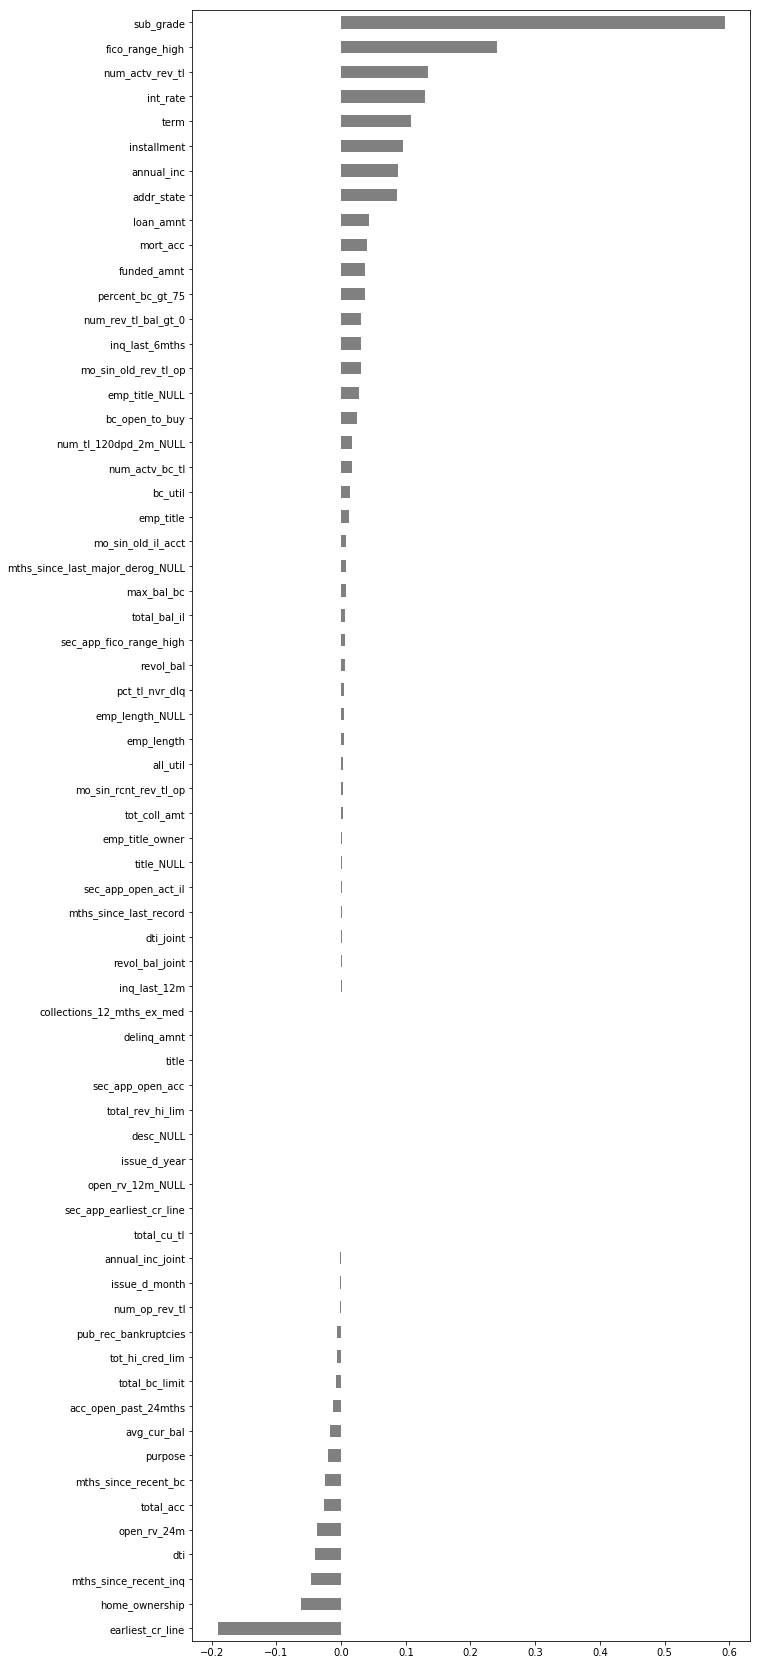

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,30))
pd.Series(shap_values[0], X_test.columns).sort_values().plot.barh(color='grey');